In [3]:
from pandas import DataFrame
import tushare as ts
# 初始化pro接口
# b179cffec140bc54a588dc96451ebff5146896dbbc5ea6b309ab6303
# 6aecc221a107b6aa227fb3d1765d85c0eeacfa2a4abf4d6d98b57023
# pro = ts.pro_api('b179cffec140bc54a588dc96451ebff5146896dbbc5ea6b309ab6303')
# df = pro.user(token='b179cffec140bc54a588dc96451ebff5146896dbbc5ea6b309ab6303')
pro = ts.pro_api('6aecc221a107b6aa227fb3d1765d85c0eeacfa2a4abf4d6d98b57023')
df = pro.user(token='6aecc221a107b6aa227fb3d1765d85c0eeacfa2a4abf4d6d98b57023')
# df = ts.pro_bar(ts_code='600000.SH',
#                     freq='1min', 
#                     start_date='2020-08-10 09:00:00', 
#                     end_date='2020-08-10 17:00:00')
df


,user_id,到期时间,到期积分


In [ ]:
%matplotlib inline
import os
os.environ["NUMEXPR_MAX_THREADS"] = "32"
from hikyuu.interactive import *


初始资金: 1000000
回测期间：19910403:20200616
总资金: 1217360.83
净收益: 217360.83


<IPython.core.display.Javascript object>

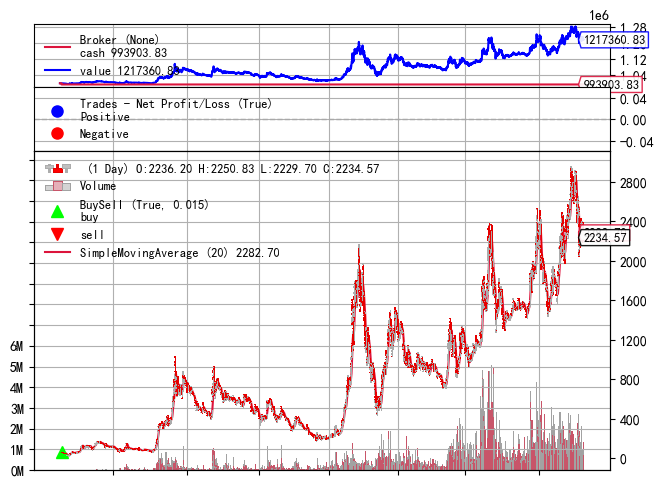

In [ ]:
from datetime import datetime

import backtrader as bt  # 升级到最新版
import matplotlib.pyplot as plt  # 由于 Backtrader 的问题，此处要求 pip install matplotlib==3.2.2
import akshare as ak  # 升级到最新版
import pandas as pd

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 利用 AKShare 获取股票的后复权数据，这里只获取前 7 列
stock_hfq_df = ak.stock_zh_a_hist(symbol="000001", adjust="hfq").iloc[:, :7]
# 删除 `股票代码` 列
del stock_hfq_df['股票代码']
# 处理字段命名，以符合 Backtrader 的要求
stock_hfq_df.columns = [
    'date',
    'open',
    'close',
    'high',
    'low',
    'volume',
]
# 把 date 作为日期索引，以符合 Backtrader 的要求
stock_hfq_df.index = pd.to_datetime(stock_hfq_df['date'])


class MyStrategy(bt.Strategy):
    """
    主策略程序
    """
    params = (("maperiod", 20),)  # 全局设定交易策略的参数

    def __init__(self):
        """
        初始化函数
        """
        self.data_close = self.datas[0].close  # 指定价格序列
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buy_price = None
        self.buy_comm = None
        # 添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod
        )

    def next(self):
        """
        执行逻辑
        """
        if self.order:  # 检查是否有指令等待执行,
            return
        # 检查是否持仓
        if not self.position:  # 没有持仓
            if self.data_close[0] > self.sma[0]:  # 执行买入条件判断：收盘价格上涨突破20日均线
                self.order = self.buy(size=100)  # 执行买入
        else:
            if self.data_close[0] < self.sma[0]:  # 执行卖出条件判断：收盘价格跌破20日均线
                self.order = self.sell(size=100)  # 执行卖出


cerebro = bt.Cerebro()  # 初始化回测系统
start_date = datetime(1991, 4, 3)  # 回测开始时间
end_date = datetime(2020, 6, 16)  # 回测结束时间
data = bt.feeds.PandasData(dataname=stock_hfq_df, fromdate=start_date, todate=end_date)  # 加载数据
cerebro.adddata(data)  # 将数据传入回测系统
cerebro.addstrategy(MyStrategy)  # 将交易策略加载到回测系统中
start_cash = 1000000
cerebro.broker.setcash(start_cash)  # 设置初始资本为 100000
cerebro.broker.setcommission(commission=0.002)  # 设置交易手续费为 0.2%
cerebro.run()  # 运行回测系统

port_value = cerebro.broker.getvalue()  # 获取回测结束后的总资金
pnl = port_value - start_cash  # 盈亏统计

print(f"初始资金: {start_cash}\n回测期间：{start_date.strftime('%Y%m%d')}:{end_date.strftime('%Y%m%d')}")
print(f"总资金: {round(port_value, 2)}")
print(f"净收益: {round(pnl, 2)}")

cerebro.plot(style='candlestick')[0][0]  # 画图


In [ ]:
from datetime import datetime

import akshare as ak
import backtrader as bt
import matplotlib.pyplot as plt  # 由于 Backtrader 的问题，此处要求 pip install matplotlib==3.2.2
import pandas as pd

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置画图时的中文显示
plt.rcParams["axes.unicode_minus"] = False  # 设置画图时的负号显示


class MyStrategy(bt.Strategy):
    """
    主策略程序
    """
    params = (("maperiod", 20),
              ('printlog', False),)  # 全局设定交易策略的参数, maperiod是 MA 均值的长度

    def __init__(self):
        """
        初始化函数
        """
        self.data_close = self.datas[0].close  # 指定价格序列
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buy_price = None
        self.buy_comm = None
        # 添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod
        )

    def next(self):
        """
        主逻辑
        """

        # self.log(f'收盘价, {data_close[0]}')  # 记录收盘价
        if self.order:  # 检查是否有指令等待执行,
            return
        # 检查是否持仓
        if not self.position:  # 没有持仓
            # 执行买入条件判断：收盘价格上涨突破15日均线
            if self.data_close[0] > self.sma[0]:
                self.log("BUY CREATE, %.2f" % self.data_close[0])
                # 执行买入
                self.order = self.buy()
        else:
            # 执行卖出条件判断：收盘价格跌破15日均线
            if self.data_close[0] < self.sma[0]:
                self.log("SELL CREATE, %.2f" % self.data_close[0])
                # 执行卖出
                self.order = self.sell()

    def log(self, txt, dt=None, do_print=False):
        """
        Logging function fot this strategy
        """
        if self.params.printlog or do_print:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        """
        记录交易执行情况
        """
        # 如果 order 为 submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f"买入:\n价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}"
                )
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(
                    f"卖出:\n价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}"
                )
            self.bar_executed = len(self)

            # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("交易失败")
        self.order = None

    def notify_trade(self, trade):
        """
        记录交易收益情况
        """
        if not trade.isclosed:
            return
        self.log(f"策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}")

    def stop(self):
        """
        回测结束后输出结果
        """
        self.log("(MA均线： %2d日) 期末总资金 %.2f 收益率:%.2f" % (self.params.maperiod, self.broker.getvalue(), (self.broker.getvalue()-1000000)/1000000*100), do_print=True)


def main(code="600070", start_cash=1000000, stake=100, commission_fee=0.001):
    cerebro = bt.Cerebro()  # 创建主控制器
    cerebro.optstrategy(MyStrategy, maperiod=range(3, 31))  # 导入策略参数寻优
    # 利用 AKShare 获取股票的后复权数据，这里只获取前 7 列
    stock_hfq_df = ak.stock_zh_a_hist(symbol=code, adjust="hfq", start_date='20000101', end_date='20210617').iloc[:, :7]
    # 删除 `股票代码` 列
    del stock_hfq_df['股票代码']
    # 处理字段命名，以符合 Backtrader 的要求
    stock_hfq_df.columns = [
        'date',
        'open',
        'close',
        'high',
        'low',
        'volume',
    ]
    # 把 date 作为日期索引，以符合 Backtrader 的要求
    stock_hfq_df.index = pd.to_datetime(stock_hfq_df['date'])
    start_date = datetime(1991, 4, 3)  # 回测开始时间
    end_date = datetime(2021, 6, 16)  # 回测结束时间
    data = bt.feeds.PandasData(dataname=stock_hfq_df, fromdate=start_date, todate=end_date)  # 规范化数据格式
    cerebro.adddata(data)  # 将数据加载至回测系统
    cerebro.broker.setcash(start_cash)  # broker设置资金
    cerebro.broker.setcommission(commission=commission_fee)  # broker手续费
    cerebro.addsizer(bt.sizers.FixedSize, stake=stake)  # 设置买入数量
    print("期初总资金: %.2f" % cerebro.broker.getvalue())
    cerebro.run(maxcpus=1)  # 用单核 CPU 做优化
    print("期末总资金: %.2f" % cerebro.broker.getvalue())


if __name__ == '__main__':
    main(code="600070", start_cash=1000000, stake=100, commission_fee=0.001)


期初总资金: 1000000.00
2021-06-16, (MA均线：  3日) 期末总资金 1009847.15 收益率:0.98
2021-06-16, (MA均线：  4日) 期末总资金 1008720.75 收益率:0.87
2021-06-16, (MA均线：  5日) 期末总资金 1010307.14 收益率:1.03
2021-06-16, (MA均线：  6日) 期末总资金 1005922.76 收益率:0.59
2021-06-16, (MA均线：  7日) 期末总资金 1005200.71 收益率:0.52
2021-06-16, (MA均线：  8日) 期末总资金 1010875.48 收益率:1.09
2021-06-16, (MA均线：  9日) 期末总资金 1011339.19 收益率:1.13
2021-06-16, (MA均线： 10日) 期末总资金 1006935.32 收益率:0.69
2021-06-16, (MA均线： 11日) 期末总资金 1007564.93 收益率:0.76
2021-06-16, (MA均线： 12日) 期末总资金 1007483.28 收益率:0.75
2021-06-16, (MA均线： 13日) 期末总资金 1011312.93 收益率:1.13
2021-06-16, (MA均线： 14日) 期末总资金 1012441.11 收益率:1.24
2021-06-16, (MA均线： 15日) 期末总资金 1012615.44 收益率:1.26
2021-06-16, (MA均线： 16日) 期末总资金 1011440.19 收益率:1.14
2021-06-16, (MA均线： 17日) 期末总资金 1011232.32 收益率:1.12
2021-06-16, (MA均线： 18日) 期末总资金 1013332.80 收益率:1.33
2021-06-16, (MA均线： 19日) 期末总资金 1012876.27 收益率:1.29
2021-06-16, (MA均线： 20日) 期末总资金 1012697.53 收益率:1.27
2021-06-16, (MA均线： 21日) 期末总资金 1014762.40 收益率:1.48
2021-06-16, (MA均线： 22日) 期末总资金 10